In [ ]:
!pip install -U langgraph langsmith

In [2]:
# Warning control
import warnings
warnings.filterwarnings('ignore')
 

 

# Système de Dialogue Interactif avec LangGraph

## Objectif
Ce code implémente un système de chat interactif utilisant LangGraph, permettant une conversation en continu avec un assistant virtuel.

## Structure et Fonctionnement

### Fonction Principale `stream_graph_updates`
- Reçoit les entrées utilisateur
- Utilise un graphe LangGraph pour traiter les messages
- Affiche les réponses de l'assistant en temps réel via streaming

### Boucle Interactive
1. Capture les entrées utilisateur en continu
2. Gère les commandes de sortie (quit, exit, q)
3. Intègre un mécanisme de fallback si l'entrée standard n'est pas disponible
  - Utilise une question par défaut : "Who kill bambi?"

### Gestion des Messages
- Format structuré : `{"role": "user", "content": message}`
- Affichage des réponses préfixées par "Assistant:"

## Utilisation
Le système fonctionne comme une interface de chat en ligne de commande, permettant une conversation naturelle avec l'assistant jusqu'à ce que l'utilisateur choisisse de quitter.

In [24]:
import os
from langchain_openai import ChatOpenAI  # Notez le changement ici

# Définition de la clé API
os.environ['OPENAI_API_KEY'] = "sk-proj-"

# Création du modèle
llm = ChatOpenAI(
    model="gpt-4o-mini",  # Notez que c'est 'model' et non 'model_name' dans les versions récentes
    temperature=0.8
)

In [25]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [26]:
from langchain_anthropic import ChatAnthropic

#llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [27]:
graph_builder.add_edge(START, "chatbot")

In [28]:
graph_builder.add_edge("chatbot", END)

In [29]:
graph = graph_builder.compile()

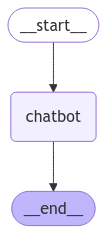

In [30]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [31]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "Who were roosevelt?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Goodbye!


# Système de Filtrage de Films avec LangGraph

## Objectif
Ce code implémente un système de filtrage de films en utilisant LangGraph, appliquant une série de filtres (genre et notation) sur une liste de films.

## Structure

### État du Système (`MovieState`)
- Gère trois listes :
 1. Films originaux (`movies`)
 2. Films filtrés par genre (`genre_filtered`)
 3. Films filtrés par notation (`rating_filtered`)

### Filtres Implémentés
1. **Filtre par Genre** (`filter_by_genre`)
  - Cible les films de science-fiction (sci-fi)
  - Premier niveau de filtrage

2. **Filtre par Notation** (`filter_by_rating`)
  - Sélectionne les films avec une note ≥ 8.0
  - S'applique sur les résultats du filtre genre

### Flux de Données
- Utilise `StateGraph` pour définir le parcours :
 1. START → Filtre Genre → Filtre Rating → END
- Traitement séquentiel garantissant l'ordre des filtres

## Exemple d'Utilisation
Inclut des données test avec trois films :
- Matrix (sci-fi, 8.7)
- Inception (sci-fi, 8.8)
- Titanic (drama, 7.9)

Le système filtre automatiquement pour ne garder que les films de sci-fi bien notés.

In [42]:
from langgraph.graph import StateGraph
from typing import TypedDict, List

class MovieState(TypedDict):
    movies: List[dict]
    genre_filtered: List[dict]
    rating_filtered: List[dict]

# On doit modifier les fonctions pour prendre l'état uniquement
def filter_by_genre(state: MovieState):
    target_genre = "sci-fi"  # Paramètre fixe
    return {
        "genre_filtered": [
            movie for movie in state["movies"] 
            if movie["genre"] == target_genre
        ]
    }

def filter_by_rating(state: MovieState):
    min_rating = 8.0  # Paramètre fixe
    return {
        "rating_filtered": [
            movie for movie in state["genre_filtered"] 
            if movie["rating"] >= min_rating
        ]
    }


# Création du graphe
graph = StateGraph(MovieState)

# Ajout des nodes de classification
graph.add_node("genre_filter", filter_by_genre)
graph.add_node("rating_filter", filter_by_rating)

graph.add_edge(START, "genre_filter")
graph.add_edge("rating_filter", END)
# Configuration du flux
graph.add_edge("genre_filter", "rating_filter")

# Exemple d'utilisation
initial_state = {
    "movies": [
        {"title": "Matrix", "genre": "sci-fi", "rating": 8.7},
        {"title": "Inception", "genre": "sci-fi", "rating": 8.8},
        {"title": "Titanic", "genre": "drama", "rating": 7.9}
    ]
}

In [43]:
# Compilation du graphe
compiled_graph = graph.compile()



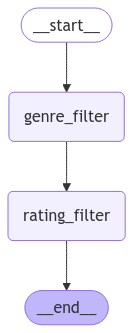

In [44]:
from IPython.display import Image, display

try:
    display(Image(compiled_graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [45]:
# Maintenant on peut lancer
results = compiled_graph.invoke({
    "movies": initial_state["movies"],
    "genre_filtered": [],
    "rating_filtered": []
})

In [46]:
print("Films filtrés:")
for film in results["rating_filtered"]:
   print(f"- {film['title']} (Note: {film['rating']})")

Films filtrés:
- Matrix (Note: 8.7)
- Inception (Note: 8.8)


# Système de Filtrage des Données de Vente Basé sur les Rôles

## Objectif
Ce code implémente un système de filtrage des données de vente utilisant LangGraph, permettant d'afficher différents niveaux d'information selon le rôle de l'utilisateur.

## Structure
- Utilise `StateGraph` de LangGraph pour gérer le flux de données
- Définit un typage strict avec `SalesState` (TypedDict)
- Implémente trois niveaux d'accès :
  1. Représentant (ROL_Sales_Rep) : voit uniquement ses ventes
  2. Manager District (ROL_District_Manager) : voit les ventes de son district
  3. Manager Zone (ROL_Area_Manager) : accès à toutes les ventes

## Fonctionnement
1. Les données de vente entrantes contiennent : ID du représentant, district, et montant
2. La fonction `filter_by_role` filtre les données selon le rôle de l'utilisateur
3. Le graphe d'état gère le flux de données : START → filtrage → END

## Utilisation
Le système est conçu pour s'intégrer dans une application plus large de gestion des ventes, permettant un accès contrôlé aux données selon la hiérarchie de l'utilisateur.

In [19]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, List

class SalesState(TypedDict):
    user_role: str
    sales_data: List[dict]
    filtered_data: List[dict]

def filter_by_role(state: SalesState):
    role = state["user_role"]
    data = state["sales_data"]
    
    if role == "ROL_Sales_Rep":
        # Représentant: voit uniquement ses ventes
        filtered = [s for s in data if s["rep_id"] == "current_user"]
    elif role == "ROL_District_Manager":
        # Manager district: voit les ventes de son district
        filtered = [s for s in data if s["district"] == "district_1"]
    else:  # ROL_Area_Manager
        # Manager zone: voit toutes les ventes
        filtered = data
        
    return {"filtered_data": filtered}

# Test data
sales_data = [
    {"rep_id": "current_user", "district": "district_1", "amount": 1000},
    {"rep_id": "other_rep", "district": "district_1", "amount": 2000},
    {"rep_id": "another_rep", "district": "district_2", "amount": 3000}
]

# Configuration du graphe
graph = StateGraph(SalesState)
graph.add_node("role_filter", filter_by_role)
graph.add_edge(START, "role_filter")
graph.add_edge("role_filter", END)

# Utilisation
compiled = graph.compile()

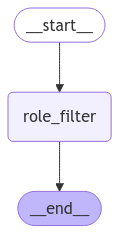

In [20]:
from IPython.display import Image, display

try:
    display(Image(compiled.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [21]:
result = compiled.invoke({
    "user_role": "ROL_Sales_Rep",
    "sales_data": sales_data,
    "filtered_data": []
})
print(result["filtered_data"])

[{'rep_id': 'current_user', 'district': 'district_1', 'amount': 1000}]
